# Lesson 29: PyTorch training loop activity

In this activity, you will modify the basic PyTorch training loop from the lesson 29 demo to add:

1. **Batching** - Process the training data in mini-batches instead of all at once
2. **Validation** - Track model performance on a held-out validation set during training

## Notebook set-up

### Imports

In [3]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Load preprocessed data

In [4]:
data = pd.read_pickle('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/preprocessed_housing_data.pkl')

training_df = data['training_df']
testing_df = data['testing_df']
features = data['features']
label = data['label']

print(f'Training samples: {len(training_df)}')
print(f'Testing samples: {len(testing_df)}')
print(f'Features: {features}')
print(f'Label: {label}')

Training samples: 15480
Testing samples: 5160
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Label: MedHouseVal


## 2. Prepare PyTorch tensors and DataLoaders

### Task 1: Add batching and validation split

Currently, the code below creates tensors for training and testing. Your task is to:

1. **Add imports** for `TensorDataset` and `DataLoader` from `torch.utils.data`
2. **Split training data** into train and validation sets (e.g., 80/20 split)
3. **Create DataLoaders** for batched training

**Hints:**
- Use `torch.randperm()` to shuffle indices for the split
- Use `TensorDataset(X, y)` to combine feature and label tensors
- Use `DataLoader(dataset, batch_size=32, shuffle=True)` to create batches
- Create separate DataLoaders for training and validation

In [5]:
# Convert dataframes to PyTorch tensors and move to device
X_train = torch.tensor(training_df[features].values, dtype=torch.float32).to(device)
y_train = torch.tensor(training_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(testing_df[features].values, dtype=torch.float32).to(device)
y_test = torch.tensor(testing_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: torch.Size([15480, 8])
y_train shape: torch.Size([15480, 1])
X_test shape: torch.Size([5160, 8])
y_test shape: torch.Size([5160, 1])


In [13]:
# NEW imports for batching
from torch.utils.data import TensorDataset, DataLoader

# --- Train/Val split (80/20) ---
val_ratio = 0.20
n = X_train.shape[0]

# shuffle indices
perm = torch.randperm(n, device=device)

val_size = int(n * val_ratio)
val_idx = perm[:val_size]
train_idx = perm[val_size:]

X_tr, y_tr = X_train[train_idx], y_train[train_idx]
X_val, y_val = X_train[val_idx], y_train[val_idx]

print("Train samples:", X_tr.shape[0])
print("Val samples:", X_val.shape[0])

# --- TensorDatasets ---
train_ds = TensorDataset(X_tr, y_tr)
val_ds   = TensorDataset(X_val, y_val)

# --- DataLoaders (batched) ---
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)



Train samples: 12384
Val samples: 3096


## 3. Build model

In [14]:
model = nn.Sequential(
    nn.Linear(8, 64), # Fully connected layer (similar to tf.keras.layers.Dense)
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 1)
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=1, bias=True)
)


## 4. Training function

### Task 2: Update training loop for batching and validation

The current training loop processes all training data at once. Your task is to modify this function to:

1. **Accept DataLoaders** instead of raw tensors
2. **Iterate over batches** in an inner loop within each epoch
3. **Compute validation metrics** after each training epoch

**Hints:**
- Change function signature to accept `train_loader` and `val_loader` instead of `X_train`, `y_train`
- Add an inner `for X_batch, y_batch in train_loader:` loop
- Accumulate loss across batches, then average for reporting
- Use `model.eval()` and `torch.no_grad()` for validation
- Track `val_loss` and `val_r2` in the history dictionary

In [ ]:
def r2_score_torch(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Compute R² = 1 - SS_res/SS_tot in torch."""
    ss_res = torch.sum((y_true - y_pred) ** 2) # <- How far are my predictions from true values?
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2) #<- How hard was this problem to begin with?
    return 1 - (ss_res / ss_tot) # 1(good) =0(no better than mean) <0(bad model)


def train_model(
    model: nn.Module, # <- your neural network
    train_loader: DataLoader, # <- yields mini-batches of training data
    val_loader: DataLoader, # <- yields mini-batches of validation data
    criterion: nn.Module, # <- loss function (MSE in your case)
    optimizer: optim.Optimizer, # <- Adam optimizer (updates weights)
    epochs: int = 50, # <- how many full passes through the training data
    print_every: int = 5 # <- how often to log progress
) -> dict[str, list[float]]:
    """
    Training loop with:
    1) Mini-batch training
    2) Validation metrics each epoch
    """
    history = {
        'loss': [], 'r2': [],
        'val_loss': [], 'val_r2': [] # <- This stores epoch-level metrics, not batch-level ones.
    }

    for epoch in range(epochs):
        # --------------------
        # TRAIN
        # --------------------
        model.train() # <- Enables Dropout, enables BatchNorm updates. Tells PyTorch: "We are learning now. 
                        #If you forget this, your model wont train correctly"
        running_loss = 0.0 # <- Tracks total loss across all batches in the epoch

        # store preds/targets to compute epoch-level R²
        y_true_train = []
        y_pred_train = []

        for X_batch, y_batch in train_loader: # <- Mini-batch loop (core learning)
            optimizer.zero_grad()

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

            # collect for R² (detach so we don't keep graph)
            y_true_train.append(y_batch.detach())
            y_pred_train.append(preds.detach())

        train_loss = running_loss / len(train_loader.dataset)
        y_true_train = torch.cat(y_true_train, dim=0)
        y_pred_train = torch.cat(y_pred_train, dim=0)
        train_r2 = r2_score_torch(y_true_train, y_pred_train).item()

        # --------------------
        # VALIDATION
        # --------------------
        model.eval()
        val_running_loss = 0.0
        y_true_val = []
        y_pred_val = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds = model(X_batch)
                loss = criterion(preds, y_batch)

                val_running_loss += loss.item() * X_batch.size(0)
                y_true_val.append(y_batch)
                y_pred_val.append(preds)

        val_loss = val_running_loss / len(val_loader.dataset)
        y_true_val = torch.cat(y_true_val, dim=0)
        y_pred_val = torch.cat(y_pred_val, dim=0)
        val_r2 = r2_score_torch(y_true_val, y_pred_val).item()

        # record
        history['loss'].append(train_loss)
        history['r2'].append(train_r2)
        history['val_loss'].append(val_loss)
        history['val_r2'].append(val_r2)

        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1}/{epochs} "
                f"- loss: {train_loss:.4f} - R²: {train_r2:.4f} "
                f"- val_loss: {val_loss:.4f} - val_R²: {val_r2:.4f}"
            )

    print("\nTraining complete.")
    return history


## 5. Train model

In [16]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=100,
    print_every=10
)


Epoch 1/100 - loss: 0.3582 - R²: 0.6402 - val_loss: 0.2617 - val_R²: 0.7426
Epoch 10/100 - loss: 0.2946 - R²: 0.7041 - val_loss: 0.2431 - val_R²: 0.7610
Epoch 20/100 - loss: 0.2776 - R²: 0.7212 - val_loss: 0.2268 - val_R²: 0.7770
Epoch 30/100 - loss: 0.2742 - R²: 0.7246 - val_loss: 0.2347 - val_R²: 0.7692
Epoch 40/100 - loss: 0.2725 - R²: 0.7263 - val_loss: 0.2607 - val_R²: 0.7436
Epoch 50/100 - loss: 0.2678 - R²: 0.7310 - val_loss: 0.2345 - val_R²: 0.7694
Epoch 60/100 - loss: 0.2689 - R²: 0.7299 - val_loss: 0.2276 - val_R²: 0.7762
Epoch 70/100 - loss: 0.2676 - R²: 0.7312 - val_loss: 0.2381 - val_R²: 0.7659
Epoch 80/100 - loss: 0.2712 - R²: 0.7276 - val_loss: 0.2160 - val_R²: 0.7876
Epoch 90/100 - loss: 0.2615 - R²: 0.7374 - val_loss: 0.2204 - val_R²: 0.7833
Epoch 100/100 - loss: 0.2663 - R²: 0.7326 - val_loss: 0.2290 - val_R²: 0.7748

Training complete.


## 6. Learning curves

**Note:** Once you add validation, update these plots to show both training and validation metrics.

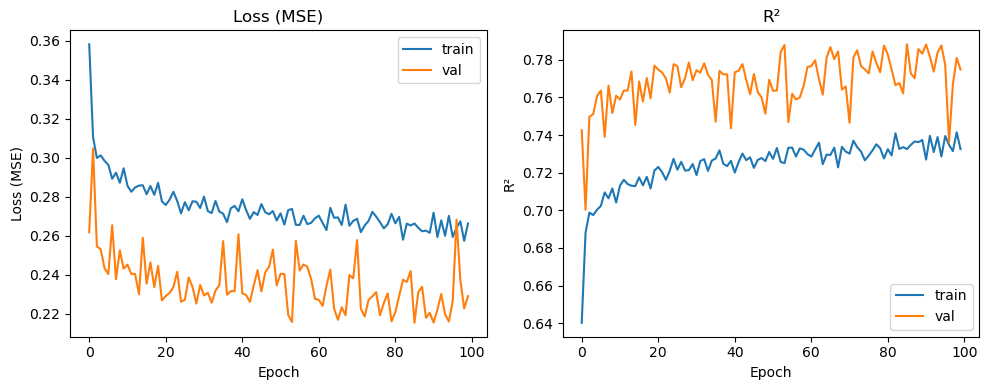

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss (MSE)')
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()

axes[1].set_title('R²')
axes[1].plot(history['r2'], label='train')
axes[1].plot(history['val_r2'], label='val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R²')
axes[1].legend()

plt.tight_layout()
plt.show()


## 7. Test set evaluation

In [18]:
# Set model to evaluation mode
model.eval()

# Make predictions (no gradient calculation needed)
with torch.no_grad():
    predictions = model(X_test).cpu().numpy().flatten()

# Calculate R²
ss_res = np.sum((testing_df[label].values - predictions) ** 2)
ss_tot = np.sum((testing_df[label].values - np.mean(testing_df[label].values)) ** 2)
rsquared = 1 - (ss_res / ss_tot)

print(f'Model R² on test set: {rsquared:.4f}')

Model R² on test set: 0.7647


## 8. Performance analysis

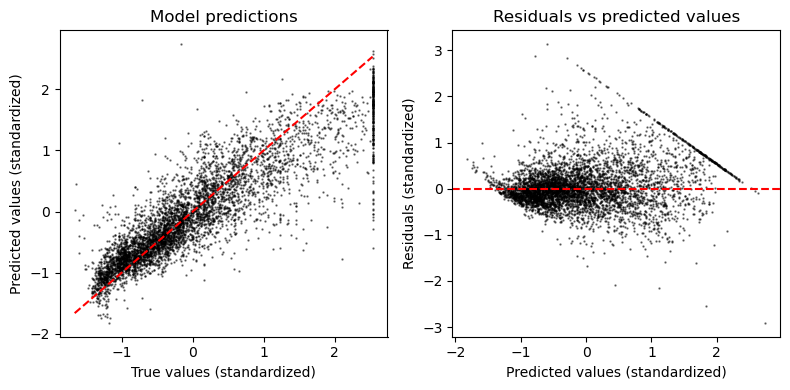

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Model predictions')
axes[0].scatter(
    testing_df[label], predictions,
    c='black', s=0.5, alpha=0.5
)
axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)
axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    predictions, testing_df[label] - predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()